In [1]:
import os 
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="2"

### Import modules

In [61]:
from tensorflow.keras.datasets import reuters
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import text_to_word_sequence

import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Embedding, Dense, LSTM, Input
from tensorflow.keras import Model
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import umap #pip install umap-learn


C:\Users\User\anaconda3\envs\ai\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Model save directory setting

In [5]:
save_path = './Results/'
if not os.path.exists(save_path):
    os.mkdir(save_path)

### Hyper-parameters

In [6]:
vocab_size = 50000
max_length = 100
embedding_dim = 10

### Data and Index load
#### Data are already be encoded as integers

In [7]:
### Load the data. The data returned will already be encoded as integers.
#### Words are ranked by how often they occur (in the training set) and only the num_words most frequent words are kept.
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=vocab_size, test_split=0.2)

### Get the index mapping integers to words from the Reuters dataset.
word_index = reuters.get_word_index()

557056/550378 [==============================] - 0s 0us/step


C:\Users\User\anaconda3\envs\ai\lib\site-packages\tensorflow\python\keras\datasets\reuters.py:148: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
C:\Users\User\anaconda3\envs\ai\lib\site-packages\tensorflow\python\keras\datasets\reuters.py:149: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


### Converting integer values to words

In [8]:
### Reverse the index to map words to integers.
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

### Decode the integer-encoded data to text. The indices have an offset of 0, 1, 2, and 3, so subtract 3. 
def decode_review(encoded_review):
    return ' '.join([reverse_word_index.get(i - 3, '?') for i in encoded_review])

'''
'?': If the dictionary does not contain a specific key, '?' Returns a character. 
This avoids errors for keys not in the dictionary, instead displaying '?' to indicate that the word is missing.

'i - 3 instead of i': 
due to the reserved indices in the word_index. 
In the Reuters dataset, there are specific reserved indices for special tokens:

0: <PAD> (Padding)
1: <START> (Start of a sequence)
2: <UNK> (Unknown word)
'''

### Now you can decode the integer-encoded review and convert it to text.
decoded_review = decode_review(train_data[0])


### Check convert result
#### Sentences are somewhat ambiguous because they have been preprocessed to some extent before performing integer encoding.

In [9]:
decoded_review

'? mcgrath rentcorp said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3'

### Check categories
#### for the detail in labels
https://martin-thoma.com/nlp-reuters/

In [10]:
Categories = np.max(train_labels) + 1
print('Categories :', Categories)
print('Train size :', train_labels.shape)


Categories : 46
Train size : (8982,)


### Sequence length setting

In [11]:
X_train = sequence.pad_sequences(train_data, maxlen=max_length)
X_test = sequence.pad_sequences(test_data, maxlen=max_length)

### One-hot encoding for labels

In [12]:
Y_train = to_categorical(train_labels)
Y_test = to_categorical(test_labels)

### Model architecture

In [17]:
InpL = Input(shape=(max_length, ))
EmbedL = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length, name='Embedd')(InpL)
LSTML = LSTM(100)(EmbedL)
DenseL = Dense(50, activation='relu')(LSTML)
Outcome = Dense(Categories, activation='softmax')(LSTML)

model = Model(InpL, Outcome)
model.compile(loss=tf.losses.categorical_crossentropy, optimizer='adam', metrics=['accuracy'])

### Pre-trained model load

In [18]:
ModelSaveSameName = save_path+'ReutersM.hdf5'

model.load_weights(ModelSaveSameName)
model.compile(loss=tf.losses.categorical_crossentropy, optimizer='adam', metrics=['accuracy'])

In [19]:
model.evaluate(X_test, Y_test, batch_size=1000)

3/3 [==============================] - 1s 70ms/step - loss: 3.3537 - accuracy: 0.5616


[3.3465588092803955, 0.5596616268157959]

### Extracting Embeddings for Words Occurring More Than a Specified Cutoff Count

In [94]:
CutoffCount = 20
UsedWord_idx, UsedWordCount = np.unique(np.concatenate(train_data), return_counts=True)
UsedWord_idx = UsedWord_idx[UsedWordCount> CutoffCount]
train_labels

EmbeddedRes = model.get_layer('Embedd').weights[0].numpy()
UsedWords = EmbeddedRes[UsedWord_idx]
UsedWords.shape

(4567, 10)

### Performing UMAP to reduce the dimensionality of word vectors

In [97]:
# Reduce dimensionality using UMAP
Reducer = umap.UMAP(n_components=2, n_neighbors=10, min_dist=0.2 )
UsedWords_2d = Reducer.fit_transform(UsedWords)

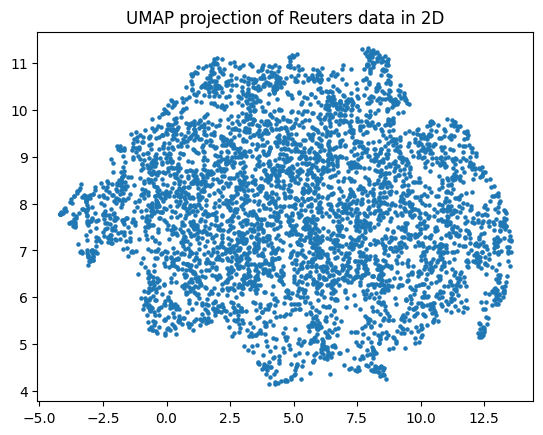

In [98]:
# Plot embeddings in 2D
plt.scatter(UsedWords_2d[:, 0], UsedWords_2d[:, 1], s=5)
plt.title('UMAP projection of Reuters data in 2D')
plt.show()